In [32]:
import numpy as np
import pandas as pd
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table
import itertools
from astroquery.simbad import Simbad
from utils import PLOT_PARAMS
from astropy import constants as const

PLOT_PARAMS()
from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
import pickle

plt.rcParams['figure.facecolor'] = 'white'
import warnings
warnings.filterwarnings("ignore")

from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

05_02_25


In [2]:
galah = Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits').to_pandas()

In [20]:
galah_vac = Table.read('../../lithium/data/GALAH_DR3_VAC_ages_v2.fits').to_pandas()

In [3]:
rv_df = pd.read_csv('comb_rvs.csv')

In [11]:
binary_list_113 = 7, 9, 11, 16, 18, 19, 21, 23  
binary_list_112 = 6, 7, 13, 23

In [36]:
def load_samples(df0,program,binary_list):
    stat_dict = {}        
    version = 1
    
    df = df0[df0.program==program]
    
    dtemp = {'RG_id':[],
             'P16':[], 'P50':[], 'P84':[],
             'e16':[], 'e50':[], 'e84':[],
             'K16':[], 'K50':[], 'K84':[] }
    
    for i, row in df.iterrows():
        RG = row.RG_id
        
        if RG not in binary_list:
            continue
        fname = '../mcmc/%s_%s_mcmc_%s.pickle'%(program,RG,version)

        with open(fname, 'rb') as handle:
            mcmc_samples = pickle.load(handle)
        
        Ps = mcmc_samples['P'].value
        es = mcmc_samples['e'].value
        Ks = mcmc_samples['K'].value
        
        dtemp['RG_id'].append(RG)
        
        dtemp['P16'].append(np.percentile(Ps, 16))
        dtemp['P50'].append(np.percentile(Ps, 50))
        dtemp['P84'].append(np.percentile(Ps, 84))
        
        dtemp['e16'].append(np.percentile(es, 16))
        dtemp['e50'].append(np.percentile(es, 50))
        dtemp['e84'].append(np.percentile(es, 84))
        
        dtemp['K16'].append(np.percentile(Ks, 16))
        dtemp['K50'].append(np.percentile(Ks, 50))
        dtemp['K84'].append(np.percentile(Ks, 84))
    
    dtemp = pd.DataFrame(dtemp)
    
    dtemp = pd.merge(dtemp, df)
    
    return dtemp

temp1 = load_samples(rv_df, 112, binary_list_112)
temp2 = load_samples(rv_df, 113, binary_list_113)


In [37]:
table1 = pd.concat([temp1, temp2])

# get mass from galah
table1 = pd.merge(table1, galah_vac[['sobject_id','m_act_bstep','e_m_act_bstep']], left_on='sobject_id', right_on='sobject_id')

In [88]:
def get_msini(df0,program,binary_list):
    version = 1
    df = df0[df0.program==program]

    dtemp = {'RG_id':[], 'Mj16':[], 'Mj50':[], 'Mj84':[], 
             'a16': [], 'a50':[], 'a84':[]
            }
    for i, row in df.iterrows():
        RG = row.RG_id
        
        if RG not in binary_list:
            continue
        fname = '../mcmc/%s_%s_mcmc_%s.pickle'%(program,RG,version)

        with open(fname, 'rb') as handle:
            mcmc_samples = pickle.load(handle)

        Ks = mcmc_samples['K'].value
        Ps = mcmc_samples['P'].value
        es = mcmc_samples['e'].value
        
        Mstar = np.array(df[(df.RG_id==RG)].m_act_bstep)[0]
        
        if str(Mstar) == 'nan':
            if df.sobject_id.values[0] == 190212001601338: # gaia DR3 3217773074208416640
                Mstar = 1.070
               
        Mjup = np.empty(len(Ks))
        a_au = np.empty(len(Ks))
        
        for i in range(len(Ks)):
            K, P, e = Ks[i], Ps[i], es[i]
            Msini, success = msini_func(K, P, e, Mstar)
            Msini_jup   = Msini/u.M_jup.to(u.kg)
            Mjup[i] = Msini_jup[0]
            
            a_m  = semi_major_axis(M1=Mstar, M2=Msini_jup, P=P)

            a_au[i] = a_m.to(u.au).value
        
        dtemp['RG_id'].append(RG)
        
        dtemp['Mj16'].append(np.percentile(Mjup, 16))
        dtemp['Mj50'].append(np.percentile(Mjup, 50))
        dtemp['Mj84'].append(np.percentile(Mjup, 84))
        
        dtemp['a16'].append(np.percentile(a_au, 16))
        dtemp['a50'].append(np.percentile(a_au, 50))
        dtemp['a84'].append(np.percentile(a_au, 84))

    dtemp = pd.DataFrame(dtemp)
    dtemp = pd.merge(dtemp, df)
    
    return dtemp

mass_temp1 = get_msini(table1, 112, binary_list_112)
mass_temp2 = get_msini(table1, 113, binary_list_113)

table2 = pd.concat([mass_temp1, mass_temp2])

In [74]:
def semi_major_axis(M1, M2, P):
    '''
    M1 : in solar masses
    P : in days
    M2 : in Mjup
    
    @return a: m
    
    '''
    G = const.G
    M1 = (M1*u.Msun).to(u.kg)
    M2 = (M2*u.Mjup).to(u.kg)
    M = (M1+M2)
    P = (P*u.day).to(u.second)
    a = (G*M*P**2/(4*np.pi**2))**(1./3)
    
    return a


In [99]:
def v_max(df):
    '''
    M1 in solar units
    M2 in Mjup units
    a in AU
    
    return v_max in km/s
    
    '''
    M1, M2 = df.m_act_bstep.to_numpy(), df.Mj50.to_numpy()
    a, e = df.a50.to_numpy(), df.e50.to_numpy()
    
    M1 = (M1*u.Msun).to(u.kg)
    M2 = (M2*u.Mjup).to(u.kg)
    M = (M1+M2)
    a = (a*u.au).to(u.m)
    M = (M1+M2)
    G = const.G

    v = ((G*M/a) * (2./(1-e) - 1))
    v = [np.sqrt(i.value) for i in v]
    v = [(i*u.m/u.s).to(u.km/u.s).value for i in v]
    
    df['v_max'] = v
    
    return df

In [100]:

def v_orb(df):
    '''
    a: in meters
    P: in days
    
    v_orb : in km/s
    
    '''
    a, P = df.a50.to_numpy(), df.P50.to_numpy()
    
    a = (a*u.au).to(u.m)
    P = (P*u.day).to(u.second)

    v = 2*np.pi*a/P
    v = [i.to(u.km/u.s).value for i in v]
    df['v_orb'] = v
    return df


In [30]:
def msini_func(K, P, e, Mstar):
    '''
    Get Mp sin(i), the minimum mass of the companion.
    @input:
        K: semi-amplitude in km/s
        P: period in days
        e: eccentricity
        M: mass of the star in solar masses
    
    '''
    from scipy import optimize
    
    # convert units to SI units
    K = (K*(u.km/u.second)).to(u.meter/u.second)
    P = (P*u.day).to(u.second)
    Mstar = (Mstar*u.M_sun).to(u.kg)
    e = e*u.dimensionless_unscaled
    
    # define constants
    pi = np.pi
    G  = const.G
    
    # if Mp << Mstar:
    Msini = (Mstar)**(2./3.) * np.sqrt(1-e**2.) * K * (P/(2*pi*G))**(1./3.)
    
    # else:
    a = np.sqrt(1-e**2.) * K * (P/(2*pi*G))**(1./3.)
    #Msini = (Mstar+Mp)**(2./3.) * a
    #fx = (Mstar+Mp)**(2./3.) * a - Msini
    
    Mjup = u.M_jup.to(u.kg)
    Msun = u.Msun.to(u.kg)
    #print(Mjup)
    def func(x, a, Mstar):
        return x - (Mstar + x)**(2./3.) * a # x = Msini

    from scipy.optimize import brentq, bisect, fsolve
    from scipy.optimize import fsolve

    sol   = optimize.root(func, Msun, args=(a.value, Mstar.value) )
    Msini = sol.x
    
    #root  = brentq(func, 0.1, Msun , args=(a.value, Mstar.value))
    
    return Msini, sol.success


In [123]:
table4 = table2.copy()

In [124]:
table4 = v_max(table4)
table4 = v_orb(table4)

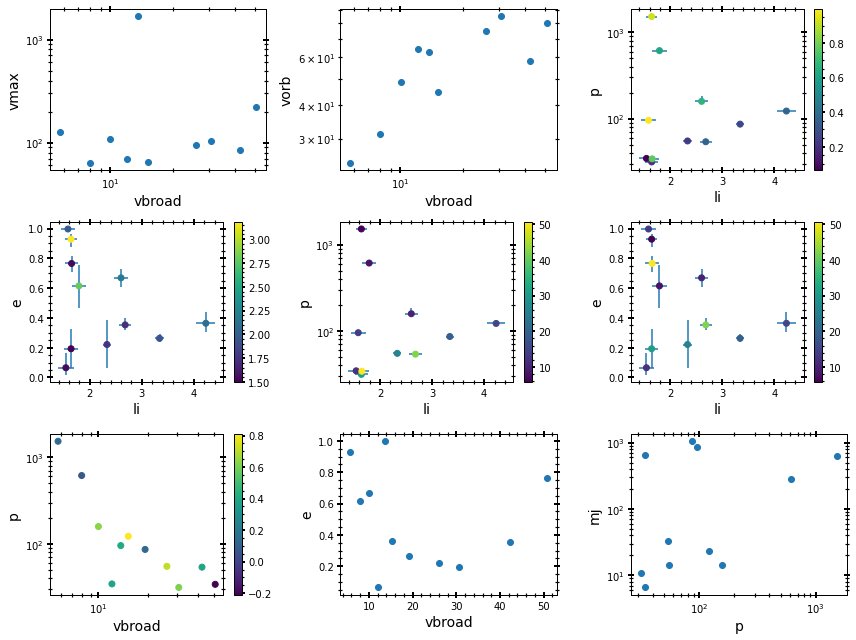

In [184]:
table3 = table4[~((table4.RG_id==23) & (table4.program==112))]

plt.figure(figsize=(12,9))
plt.subplot(331)
plt.scatter(table3.vbroad,table3.v_max)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('vbroad')
plt.ylabel('vmax')

plt.subplot(332)
plt.scatter(table3.vbroad,table3.v_orb)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('vbroad')
plt.ylabel('vorb')

plt.subplot(333)
plt.errorbar(table3.Li_val, table3.P50, xerr=table3.e_Li_val,yerr=[table3.P50-table3.P16,table3.P84-table3.P50],fmt='o',mfc='None',mec='None')
plt.scatter(table3.Li_val, table3.P50,c=table3.e50.to_numpy(),zorder=100)
plt.colorbar()
plt.xlabel('li')
plt.ylabel('p')
plt.yscale('log')

plt.subplot(334)
plt.errorbar(table3.Li_val, table3.e50, xerr=table3.e_Li_val, yerr=[table3.e50-table3.e16,table3.e84-table3.e50],fmt='o',mfc='None',mec='None')
plt.scatter(table3.Li_val, table3.e50,c=np.log10(table3.P50.to_numpy()),zorder=100)
plt.colorbar()
plt.xlabel('li')
plt.ylabel('e')


plt.subplot(335)
plt.errorbar(table3.Li_val, table3.P50, xerr=table3.e_Li_val,yerr=[table3.P50-table3.P16,table3.P84-table3.P50],fmt='o',mfc='None',mec='None')
plt.scatter(table3.Li_val, table3.P50,c=table3.vbroad.to_numpy(),zorder=100)
plt.colorbar()
plt.xlabel('li')
plt.ylabel('p')
plt.yscale('log')


plt.subplot(336)
plt.errorbar(table3.Li_val, table3.e50, xerr=table3.e_Li_val, yerr=[table3.e50-table3.e16,table3.e84-table3.e50],fmt='o',mfc='None',mec='None')
plt.scatter(table3.Li_val, table3.e50,c=table3.vbroad.to_numpy(),zorder=100)
plt.colorbar()
plt.xlabel('li')
plt.ylabel('e')

plt.subplot(337)
plt.scatter(table3.vbroad, table3.P50,c=table3.Ba_fe)
plt.colorbar()
plt.xlabel('vbroad')
plt.ylabel('p')
plt.yscale('log')
plt.xscale('log')


plt.subplot(338)
plt.scatter(table3.vbroad, table3.e50)
plt.ylabel('e')
plt.xlabel('vbroad')


plt.subplot(339)
plt.scatter(table3.P50, (table3.Mj50*u.Mjup))
plt.xscale('log')
plt.yscale('log')
plt.ylabel('mj')
plt.xlabel('p')

plt.tight_layout()

In [173]:
table3[['RG_id','program','P50','v_max','e50','vbroad','e50']].sort_values(by='P50')

,RG_id,program,P50,v_max,e50,vbroad,e50
2,11,113,31.517923,103.180227,0.193047,30.59,0.193047
3,16,113,34.236376,221.572751,0.765700,50.70,0.765700
1,9,113,34.620994,68.876268,0.065456,12.10,0.065456
5,19,113,54.001598,83.848101,0.353373,42.21,0.353373
6,21,113,55.167827,94.008600,0.221503,25.94,0.221503
2,13,112,86.425657,NaN,0.263000,19.17,0.263000
4,18,113,95.724711,1673.255420,0.997206,13.68,0.997206
0,7,113,122.559742,65.365230,0.364026,15.18,0.364026
1,7,112,158.760071,109.447640,0.669294,10.03,0.669294
0,6,112,614.328998,63.903097,0.615072,7.95,0.615072
